In [1]:
# !pip install --upgrade setuptools
!pip install grpcio
!pip install tensorflow
!pip install tensorflow-cpu
!pip install tensorflow-intel
!pip install tensorflowjs
!pip3 install tensorflow_decision_forests
!pip install seaborn
!pip install matplotlib
!pip install ultralytics
!pip install graphviz

In [2]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
import pandas as pd
import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
import math

dataset = pd.read_csv('../data/train.csv')
dataset_test_id = pd.read_csv('../data/test.csv')
y_pred = pd.read_csv('../data/sample_submission.csv')

2024-02-04 00:39:01.359563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#dataset = dataset.drop('Id', axis=1)
dataset_test = dataset_test_id.drop('Id', axis=1)
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/var/folders/k2/wk5cxz6149101m06fddkxgn80000gn/T/ipykernel_94108/3010099981.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


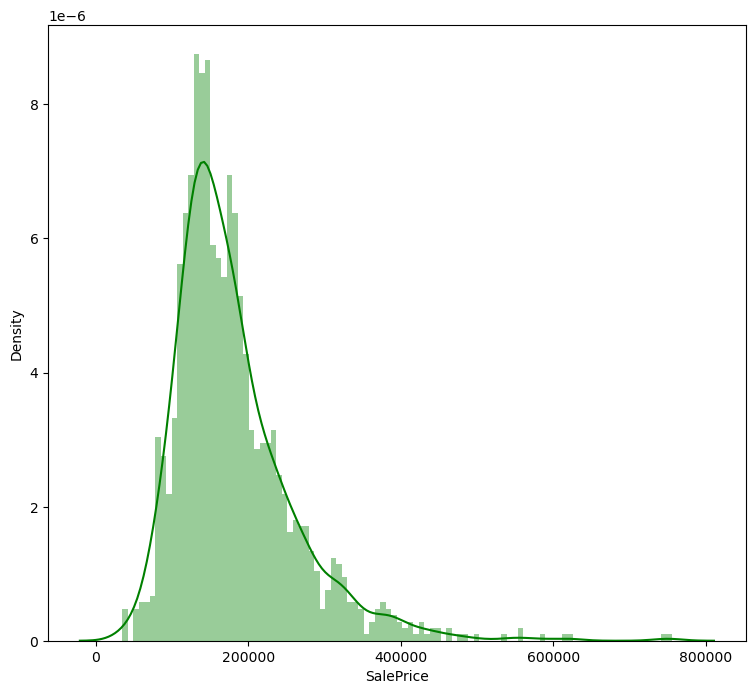

In [6]:
print(dataset['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

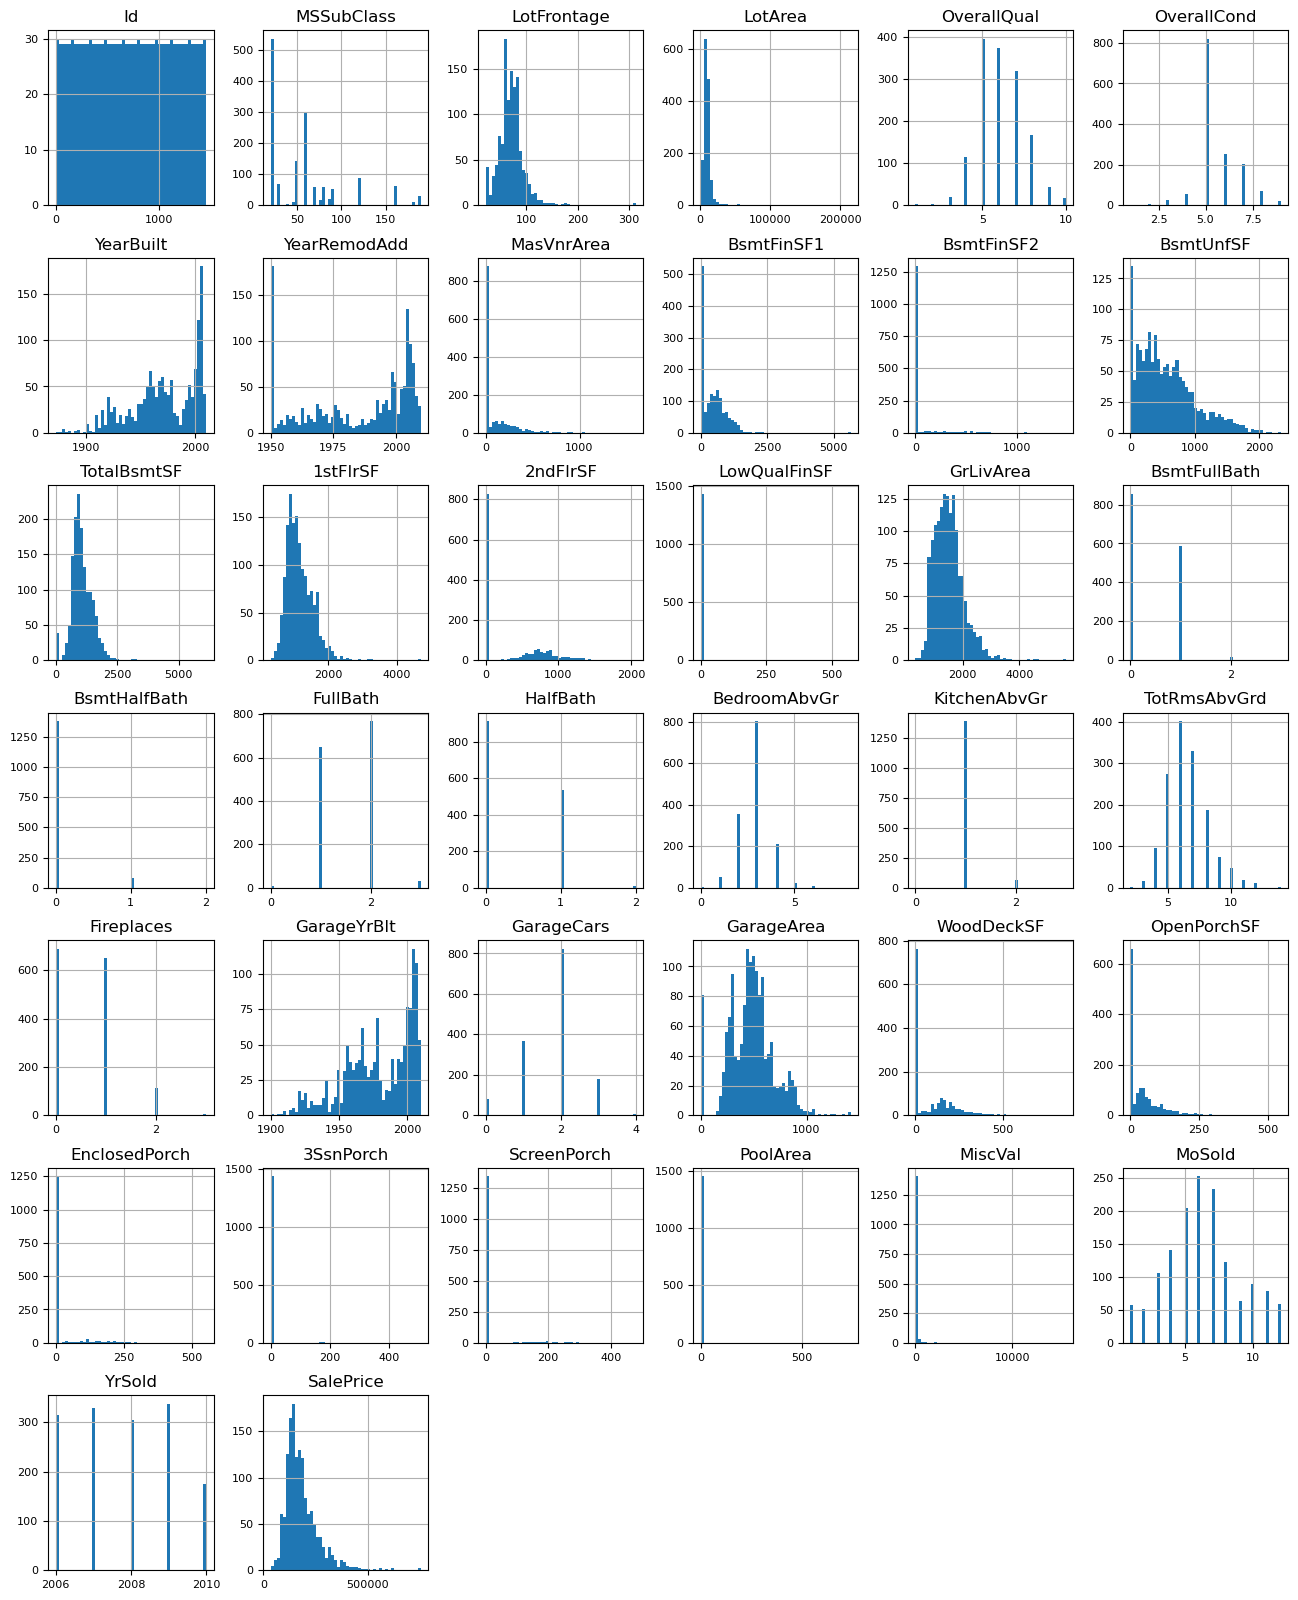

In [7]:
df_num = dataset.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [8]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

#train_ds_pd, valid_ds_pd = split_dataset(dataset)
#print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len(valid_ds_pd)))

1013 examples in training, 447 examples in testing.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Trabajo con pred:
base_test = dataset_test_id.merge(y_pred, left_on='Id', right_on='Id')

# Unimos test-train
base_test['Base'] = 0 #test
dataset['Base'] = 1 #train

base_general = pd.concat([base_test, dataset], ignore_index=True)

# Limpiamos la info: creamos dummies y limpiamos nan
base_general = pd.get_dummies(base_general)
base_general = clean_dataset(base_general)

# Separamos las bases
train_df = base_general[base_general.Base == 1]
test_df = base_general[base_general.Base == 0]

train_df = train_df.drop('Base', axis=1)
test_df = test_df.drop('Base', axis=1)
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df["SalePrice"]

X_test = test_df.drop('SalePrice', axis=1)
y_test = test_df["SalePrice"]

In [10]:
null_count_ser = pd.isna(dataset_test_id).sum()
is_null_ser = null_count_ser > 0
null_count_ser[is_null_ser]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [31]:
rf = RandomForestRegressor()
# Train the model on training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred=list(y_pred)

In [12]:
y_test=list(y_test)
#y_pred=[round(num) for num in y_pred]

In [19]:
from sklearn.metrics import r2_score
accuracy = r2_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: -20.617608990395087


In [20]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/Users/pablomartinez/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x162b48a90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1642b8490>})

In [21]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 163}


In [25]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

In [32]:
accuracy = r2_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: -20.764075770621172


In [33]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MAE: 54655.58307633029


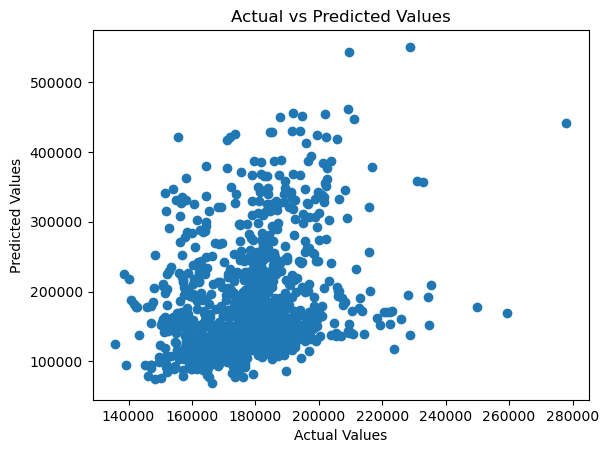

In [34]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()